## <b><u>Section 01:-</u> Import Libraries & Data</b>

In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [437]:
data=pd.read_csv("airline-passenger-traffic.csv")
data.columns=['Month','Passengers']
data['Month']=pd.to_datetime(data['Month'],format='%Y-%m')
data=data.set_index('Month')
data.head(5)

,Passengers
Month,
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0


## <b><u>Section 02:-</u> Data Cleaning & EDA</b>

### <b><u>Part 01:-</u> Checking for the missing value present & Treating them</b>

In [438]:

total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['No of Missing Values', 'Percent']).transpose()

,Passengers
No of Missing Values,4.000000
Percent,2.797203


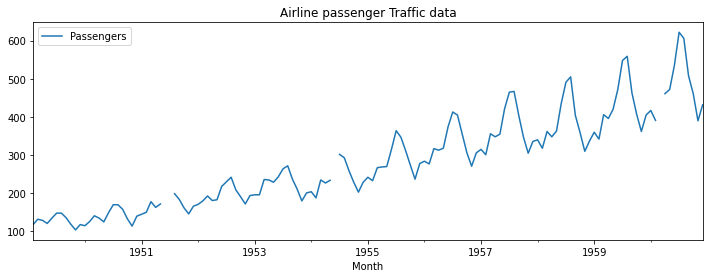

In [439]:
data.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title("Airline passenger Traffic data")
plt.show(block=False)

#### <b><u>Method 01:-</u> Mean Imputation</b>

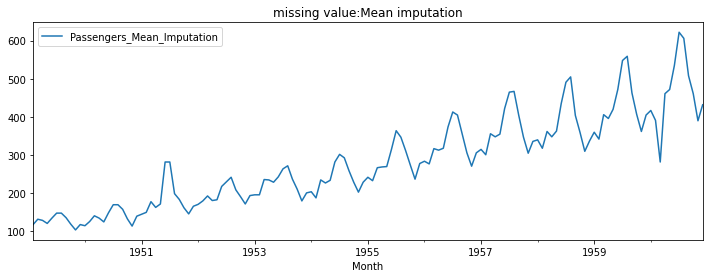

In [440]:
data=data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title("missing value:Mean imputation")
plt.show(block=False)


#### <b><u>Method 02:-</u> Linear Interpolation Imputation</b>

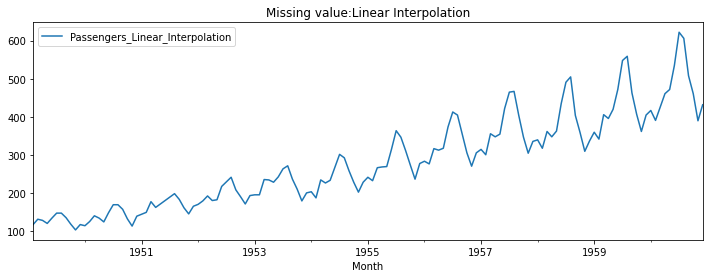

In [441]:
data=data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title("Missing value:Linear Interpolation")
plt.show(block=False)


#### <b><u>Conclusion:-</u> Using Method 02 linear interpolation to impute missing value</b>

In [442]:
data['Passengers']=data['Passengers_Linear_Interpolation']

### <b><u>Part 02:-</u> Outlier Detection </b>

count    143.000000
mean     281.510490
std      119.633411
min      104.000000
25%      181.000000
50%      268.000000
75%      361.000000
85%      411.200000
90%      455.800000
100%     622.000000
max      622.000000
Name: Passengers, dtype: float64


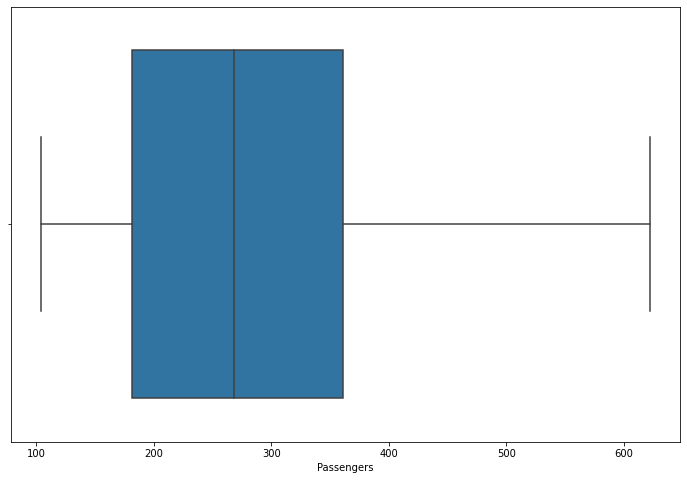

In [443]:
print(data.Passengers.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))
sns.boxplot(x='Passengers',data=data)

In [444]:
df_outlier=data[['Passengers']]

Q1 = df_outlier.quantile(0.25)
Q3 = df_outlier.quantile(0.75)
IQR = Q3 - Q1
print("IQR is:-",IQR)

print("Number of Outliers:-",((df_outlier < (Q1 - 1.5 * IQR)) | (df_outlier > (Q3 + 1.5 * IQR))).sum())

IQR is:- Passengers    180.0
dtype: float64
Number of Outliers:- Passengers    0
dtype: int64


### <b><u>Part 03:-</u> Time Series Decomposition </b>

#### <b> Additive seasonal decomposition </b>

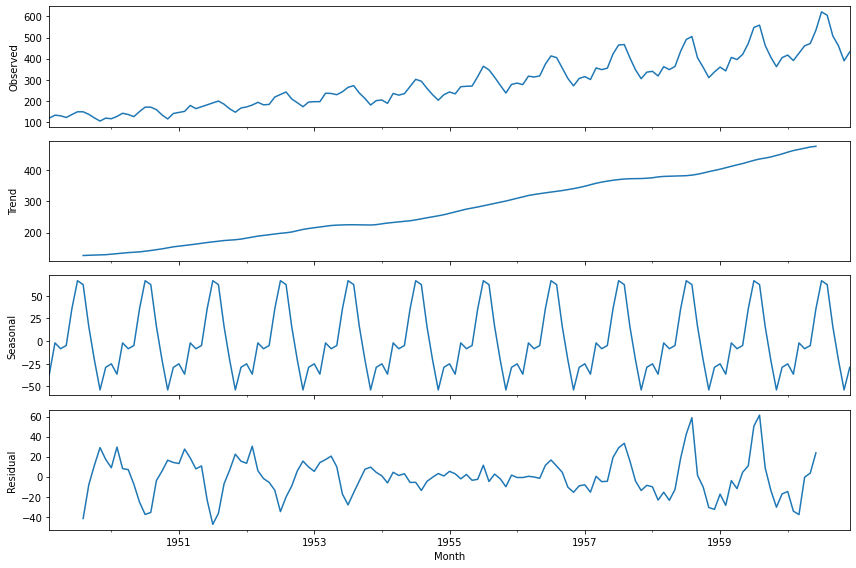

In [445]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize']=12,8
decomposition=sm.tsa.seasonal_decompose(data.Passengers,model='additive')
fig=decomposition.plot()

### <b> Multiplicative Seasonal Decomposition</b>

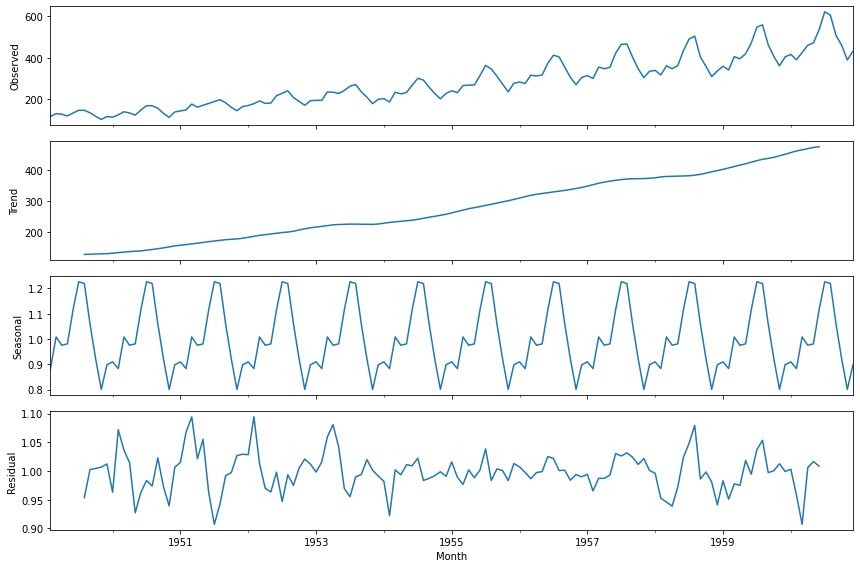

In [446]:
decomposition=sm.tsa.seasonal_decompose(data.Passengers,model='multiplicative')
fig=decomposition.plot()

## <b><u>Section 03:-</u> Build Evaluate time series forcast</b>

### <b> Splitting time series into Training and Test sets</b>

In [447]:
train_len=120
train=data[:train_len]
test=data[train_len:]

### <b>Different Forecasting Methods</b>

#### <b><u>Method 01:-</u> Naive Method </b>

In [448]:
y_hat_naive=test.copy()
y_hat_naive['naive_forecast']=train['Passengers'][train_len-1]

##### <b> Plot Train,test Forcast</b>

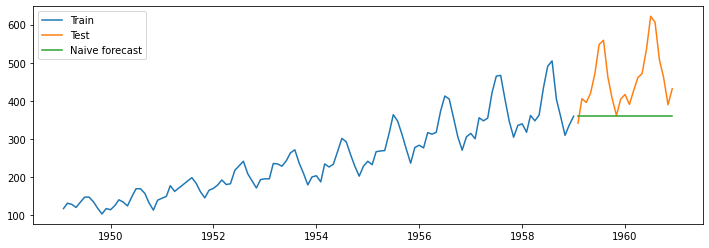

In [449]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_naive['naive_forecast'],label='Naive forecast')
plt.legend(loc='best')

##### <b> Calculate RMSE and MAPE to evaluate forecast On Naive Method </b>

In [450]:
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_naive['naive_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results=pd.DataFrame({'Method':['Naive method'],'Mape':[mape],'RMSE':[rmse]})
results=results[['Method','RMSE','Mape']]
results

,Method,RMSE,Mape
0,Naive method,121.4,19.68


#### <b><u>METHOD 02:-</u> Sime Average Method </b>

In [451]:
y_hat_avg=test.copy()
y_hat_avg['avg_forecast']=train['Passengers'].mean()

##### <b> Plot Train,test and Forcast</b>

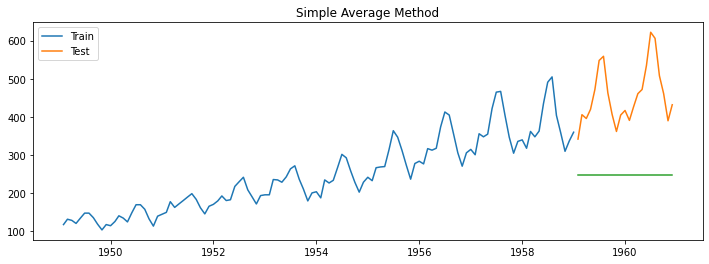

In [452]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_avg['avg_forecast'])
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

##### <b> Calculate RMSE and MAPE to evaluate forecast On Simple Average Method(Sime) </b>

In [453]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_avg['avg_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Simple Average Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.4,19.68
0,Simple Average Method,221.2,44.36


#### <b><u>Method 03:-</u>Simple Moving Average Method</b>

In [454]:
y_hat_sma=data.copy()
ma_windows=12
y_hat_sma['sma_forecast']=data['Passengers'].rolling(ma_windows).mean()
y_hat_sma['sma_forecast'][train_len:]=y_hat_sma['sma_forecast'][train_len-1]

##### <b> Plot,train, test and forecast </b>

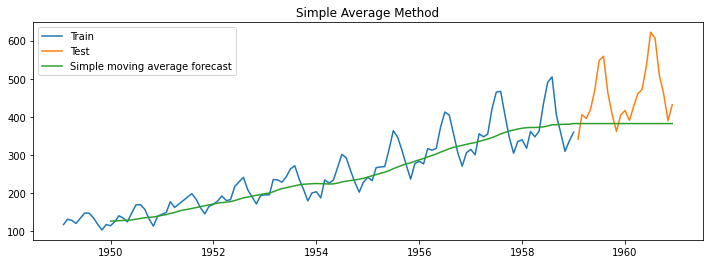

In [455]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'],label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

##### <b> Calculate RMSE and MAPE to evaluate forecast On Simple Moving Average Method(Sime) </b>

In [456]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_sma['sma_forecast'][train_len:])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Simple Moving Average Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67


#### <b><u>Method 04:-</u>Simple Exponential Smoothing Method</b>

In [457]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model=SimpleExpSmoothing(train['Passengers'])
model_fit=model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses=test.copy()
y_hat_ses['ses_forecast']=model_fit.forecast(24)


#### <b>Plot Train,test and forecast</b>

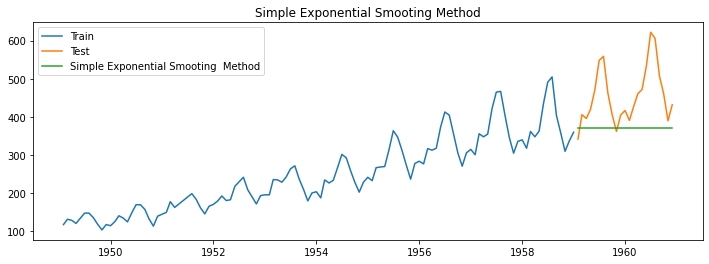

In [458]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_ses['ses_forecast'],label='Simple Exponential Smooting  Method')
plt.legend(loc='best')
plt.title('Simple Exponential Smooting Method')
plt.show()


##### <b> Calculate RMSE and MAPE to evaluate forecast On Simple exponential smoothing method </b>

In [459]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_ses['ses_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Simple Exponential Smoothing Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55


#### <b><u>Method 04:-</u>Holt Exponential Smoothing Method</b>

In [460]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model= ExponentialSmoothing(np.array(train['Passengers']),seasonal_periods=12,trend='additive')
model_fit=model.fit(smoothing_level=0.2,smoothing_slope=0.01,optimized=False)
print(model_fit.params)

y_hat_holt=test.copy()
y_hat_holt['holt_forecast']=model_fit.forecast(23)

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 118.0, 'initial_slope': 14.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### <b>Plot Train,test and forecast</b>

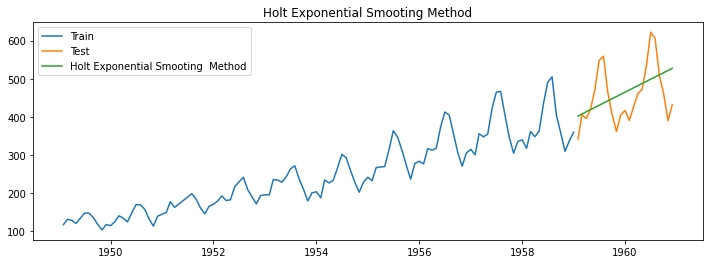

In [461]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_holt['holt_forecast'],label='Holt Exponential Smooting  Method')
plt.legend(loc='best')
plt.title('Holt Exponential Smooting Method')
plt.show()


##### <b> Calculate RMSE and MAPE to evaluate forecast On Holt Exponential Smoothing Method </b>

In [462]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_holt['holt_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Holt Exponential Smoothing Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75


#### <b><u>Method 05:-</u>Holt Winter's Exponential Smoothing Additive & Multiplicative Method</b>

##### <b><u>Type 01:-</u>Holt Winter's Exponential Smoothing Additive Method</b>

In [463]:
y_hat_hwa=test.copy()
model= ExponentialSmoothing(np.array(train['Passengers']),seasonal_periods=12,trend='add',seasonal='add')

model_fit=model.fit(optimized=True)
print(model_fit.params)

y_hat_hwa['hwa_forecast']=model_fit.forecast(23)

{'smoothing_level': 0.2631578925349059, 'smoothing_slope': 0.050534786607501735, 'smoothing_seasonal': 0.7368421030612217, 'damping_slope': nan, 'initial_level': 206.84461903965106, 'initial_slope': 2.094331763649625, 'initial_seasons': array([ -90.2252261 ,  -76.40603092,  -79.66930304,  -87.75806045,
        -73.744828  ,  -60.81774408,  -61.013332  ,  -73.21638438,
        -90.3711736 , -105.25650203,  -90.91911081,  -93.85787631]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


###### <b>Plot Train,test and forecast</b>

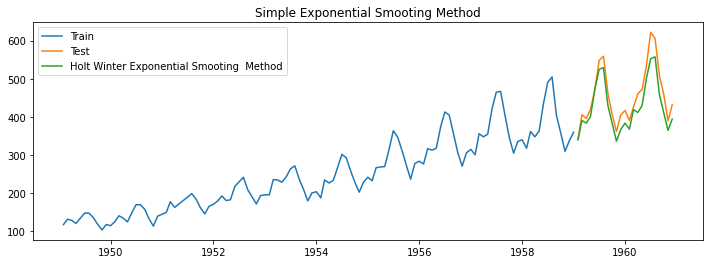

In [464]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_hwa['hwa_forecast'],label='Holt Winter Exponential Smooting  Method')
plt.legend(loc='best')
plt.title('Simple Exponential Smooting Method')
plt.show()


###### <b> Calculate RMSE and MAPE to evaluate forecast On Holt winters Additive Method </b>

In [465]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_hwa['hwa_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hwa_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Holt Winters\' Additive Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37


##### <b><u>Type 02:-</u>Holt Winter's Exponential Smoothing Multiplicative Method</b>

In [466]:
y_hat_hwm=test.copy()
model= ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12,trend='add',seasonal='mul')

model_fit=model.fit(optimized=True)
print(model_fit.params)

y_hat_hwm['hwm_forecast']=model_fit.forecast(23)

{'smoothing_level': 0.3157894736526667, 'smoothing_slope': 0.05263126447168318, 'smoothing_seasonal': 0.6842105262842456, 'damping_slope': nan, 'initial_level': 208.69981154960635, 'initial_slope': 1.2712443485667102, 'initial_seasons': array([0.58965376, 0.64430462, 0.61485636, 0.56784817, 0.63010543,
       0.69306308, 0.69284049, 0.63396818, 0.55133878, 0.48738474,
       0.56998034, 0.56536063]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


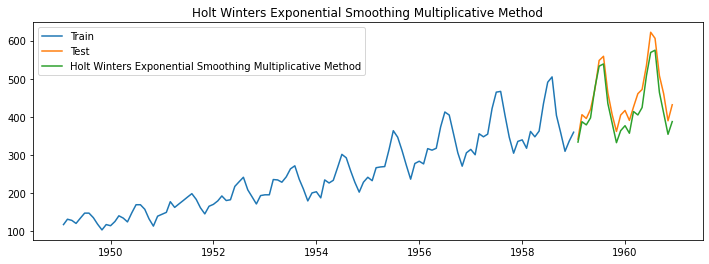

In [467]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')

plt.plot(y_hat_hwm['hwm_forecast'],label='Holt Winters Exponential Smoothing Multiplicative Method')
plt.legend(loc='best')
plt.title('Holt Winters Exponential Smoothing Multiplicative Method')
plt.show()


In [468]:
rmse=np.sqrt(mean_squared_error(test['Passengers'],y_hat_hwm['hwm_forecast'])).round(2)
mape=np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hwm_forecast'])/test['Passengers'])*100,2)

tempResults=pd.DataFrame({'Method':['Holt Winters\' Multiplicative Method'],'Mape':[mape],'RMSE':[rmse]})
results=pd.concat([results,tempResults])
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69


# <b>Auto Regressive methods</b>

### <b><u>Converting Non Stationary  data points to stationary time series</u></b>

#### <b><u>Stationary vs Non stationary time series</u>

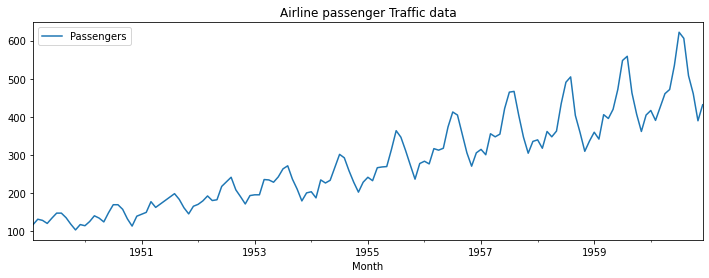

In [469]:
data['Passengers'].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title("Airline passenger Traffic data")
plt.show(block=False)

### <b><u>Augumented Dickey-Fuller(ADF) test</u></b>


In [470]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(data['Passengers'])

print('ADF statistics:%f'% adf_test[0])
print("critical value of @ 0.05:%.2f"%adf_test[4]['5%'])
print('p-value: %f'% adf_test[1])

ADF statistics:0.866288
critical value of @ 0.05:-2.88
p-value: 0.992634


### <b><u> Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test</u></b>


In [471]:
from statsmodels.tsa.stattools import kpss
kpss_test=kpss(data['Passengers'])

print('kpss statistics:%f'% kpss_test[0])
print("critical value of @ 0.05:%.2f"%kpss_test[3]['5%'])
print('p-value: %f'% kpss_test[1])

kpss statistics:1.044840
critical value of @ 0.05:0.46
p-value: 0.010000


####<b> BOX COX TRANSFORMATION TO MAKE VARIANCE CONSTANT</b>

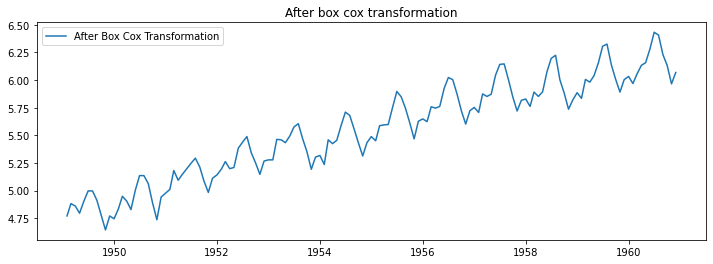

In [472]:
from scipy.stats import boxcox
data_boxcox=pd.Series(boxcox(data['Passengers'],lmbda=0),index=data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox Transformation')
plt.legend(loc='best')
plt.title('After box cox transformation')
plt.show()

##<b> Differencing To Remove Trend </b>

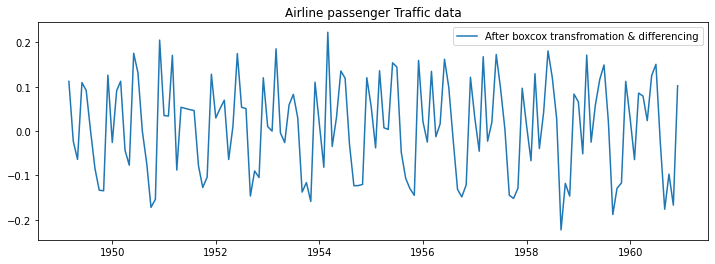

In [473]:
data_boxcox_diff=pd.Series(data_boxcox-data_boxcox.shift(),index=data.index)
data_boxcox_diff.dropna(inplace=True)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff,label="After boxcox transfromation & differencing")
plt.legend(loc='best')
plt.title("Airline passenger Traffic data")
plt.show(block=False)

###<b> After Box Cox transformation testing for Stationarity using ADF </b>

In [474]:
adf_test=adfuller(data_boxcox_diff)

print('ADF statistics:%f'% adf_test[0])
print("critical value of @ 0.05:%.2f"%adf_test[4]['5%'])
print('p-value: %f'% adf_test[1])

ADF statistics:-3.267370
critical value of @ 0.05:-2.88
p-value: 0.016402


###<b> After Box Cox transformation testing for Stationarity using Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test</b>

In [475]:
kpss_test=kpss(data_boxcox_diff)

print('kpss statistics:%f'% kpss_test[0])
print("critical value of @ 0.05:%.2f"%kpss_test[3]['5%'])
print('p-value: %f'% kpss_test[1])

kpss statistics:0.090523
critical value of @ 0.05:0.46
p-value: 0.100000


## <b>Autocorrelation function (ACF)</b>

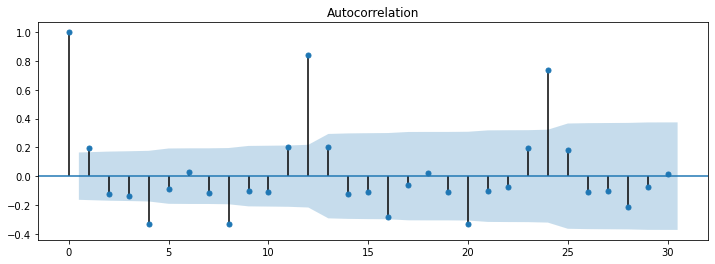

In [476]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## <b>Partial autocorrelation function (PACF)</b>

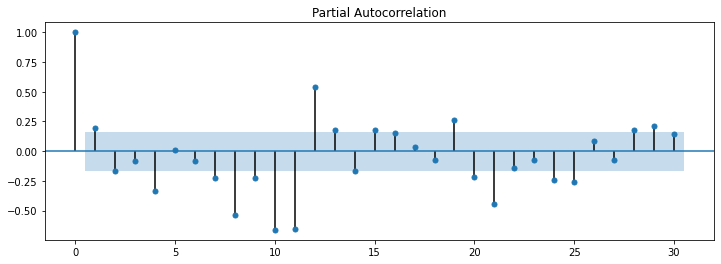

In [477]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [478]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [479]:
train_data_boxcox_diff

Month
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
                ...   
1958-09-01   -0.223144
1958-10-01   -0.118092
1958-11-01   -0.146750
1958-12-01    0.083511
1959-01-01    0.066021
Length: 119, dtype: float64

## Auto regression method (AR)

In [480]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.009674
ar.L1.y    0.183689
dtype: float64


### Recover original time series

In [481]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

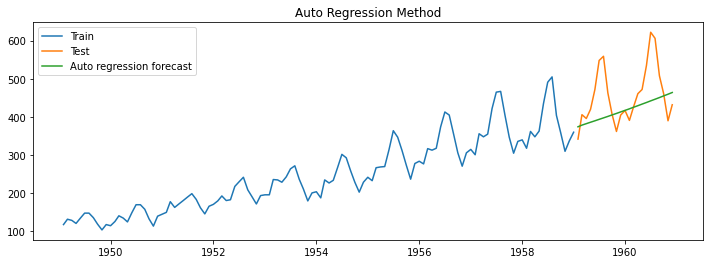

In [482]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [483]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'],'Mape': [mape] , 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
#results = results[['Method', 'RMSE', 'MAPE']]
results


,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69
0,Autoregressive (AR) method,79.56,11.52


## Moving average method (MA)

In [484]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.009669
ma.L1.y    0.268926
dtype: float64


### Recover original time series

In [485]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

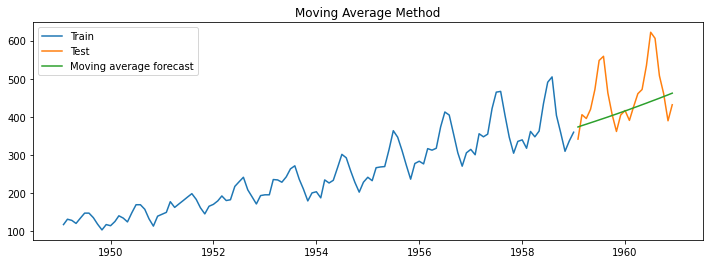

In [486]:
plt.figure(figsize=(12,4))
plt.plot(data['Passengers'][:train_len], label='Train')
plt.plot(data['Passengers'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [487]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'Mape': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'Mape']]
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69
0,Autoregressive (AR) method,79.56,11.52
0,Moving Average (MA) method,80.33,11.66


## Auto regression moving average method (ARMA)

In [488]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.009224
ar.L1.y   -0.534431
ma.L1.y    0.803363
dtype: float64


## Recover original time series

In [489]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

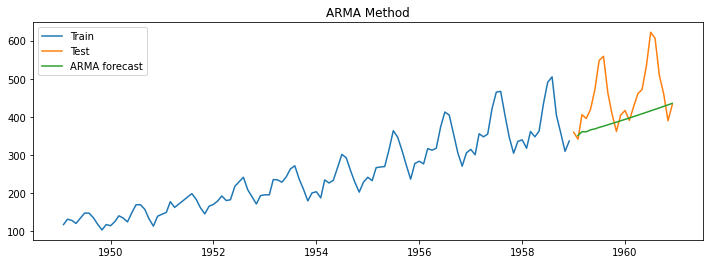

In [490]:
plt.figure(figsize=(12,4))
plt.plot( data['Passengers'][:train_len-1], label='Train')
plt.plot(data['Passengers'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [491]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arma['arma_forecast'][train_len-1:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'Mape': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'Mape']]
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69
0,Autoregressive (AR) method,79.56,11.52
0,Moving Average (MA) method,80.33,11.66
0,Autoregressive moving average (ARMA) method,93.26,13.80


## Auto regressive integrated moving average (ARIMA)

In [492]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.009224
ar.L1.D.y   -0.534431
ma.L1.D.y    0.803363
dtype: float64


### Recover original time series forecast

In [493]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

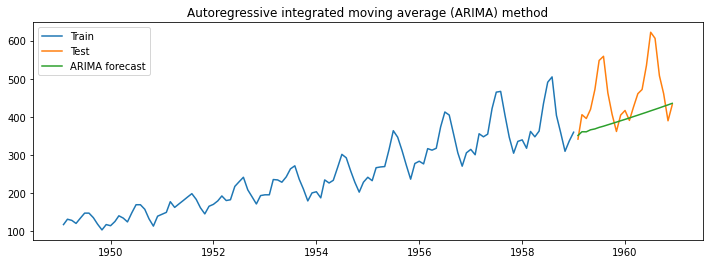

In [494]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [495]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'Mape': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'Mape']]
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69
0,Autoregressive (AR) method,79.56,11.52
0,Moving Average (MA) method,80.33,11.66
0,Autoregressive moving average (ARMA) method,93.26,13.80


## Seasonal auto regressive integrated moving average (SARIMA)

In [496]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.392580
ma.L1      -0.692513
ar.S.L12   -0.049361
ma.S.L12   -0.510314
sigma2      0.001415
dtype: float64


### Recover original time series forecast

In [497]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

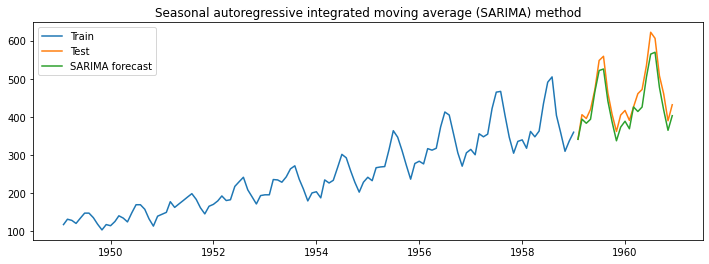

In [498]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [499]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'Mape': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'Mape']]
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69
0,Autoregressive (AR) method,79.56,11.52
0,Moving Average (MA) method,80.33,11.66
0,Autoregressive moving average (ARMA) method,93.26,13.80


## Seasonal auto regressive integrate moving average with exogenous variable (SARIMAX)

### Import promotion data

In [500]:
promo = pd.read_csv('promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


### Split promotion data into train and test data sets

In [506]:
train_len=120
train=data[:train_len]
test=data[train_len:]

promo_train = promo[:train_len]
promo_test = promo[train_len:]

### Build SARIMAX model

In [508]:
train_data_boxcox = promo[:train_len]


model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train,initialization='approximate_diffuse') 
model_fit = model.fit()
print(model_fit.params)

Event       1.000000e+00
ar.L1      -3.039825e-16
ma.L1      -7.500000e-01
ar.S.L12   -9.922618e-16
ma.S.L12    2.602085e-15
sigma2      1.000000e-10
dtype: float64


### Recover original time series forecast

In [509]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(), exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

### Plot train, test and forecast

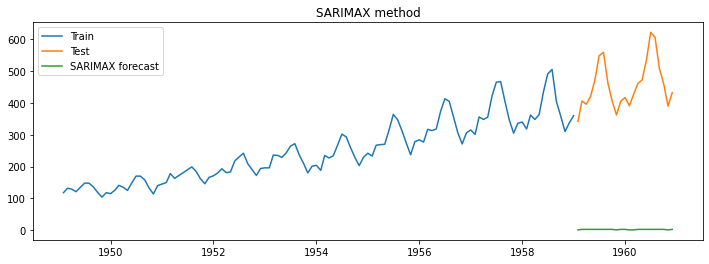

In [510]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

### Calculate RMSE and MAPE

In [512]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMAX method'], 'RMSE': [rmse],'Mape': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'Mape']]
results

,Method,RMSE,Mape
0,Naive method,121.40,19.68
0,Simple Average Method,221.20,44.36
0,Simple Moving Average Method,104.28,15.67
0,Simple Exponential Smoothing Method,112.15,17.55
0,Holt Exponential Smoothing Method,71.27,12.75
0,Holt Winters' Additive Method,34.13,6.37
0,Holt Winters' Multiplicative Method,33.63,6.69
0,Autoregressive (AR) method,79.56,11.52
0,Moving Average (MA) method,80.33,11.66
0,Autoregressive moving average (ARMA) method,93.26,13.80
